# Modelling

In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

In [47]:
b = pd.read_csv('Potentail_Bust_Stops_lat_long_corrected.csv').drop(columns="Unnamed: 0")
a = pd.read_csv('Employee_Addresses_lat_long.csv').set_index('employee_id')
b

,Street_One,Street_Two,latitude,longitude
0,MISSION ST,ITALY AVE,37.718475,-122.439532
1,MISSION ST,NEW MONTGOMERY ST,37.787462,-122.400526
2,MISSION ST,01ST ST,37.789782,-122.397587
3,MISSION ST,20TH ST,37.758648,-122.419081
4,MISSION ST,FREMONT ST,37.790474,-122.396721
...,...,...,...,...
114,MISSION ST,NIAGARA AVE,37.715586,-122.441725
115,MISSION ST,ACTON ST,37.708808,-122.452707
116,MISSION ST,05TH ST,37.782731,-122.406509
117,MISSION ST,24TH ST,37.752248,-122.418458


In [48]:
a

,address,latitude,longitude
employee_id,,,
1,"220 Surrey St, San Francisco, CA 94131, USA",37.735914,-122.435537
2,"110 Madrid St, San Francisco, CA 94112, USA",37.727706,-122.428450
3,"1224 Athens St, San Francisco, CA 94112, USA",37.712354,-122.436421
4,"171 Accacia St, Daly City, CA 94014, USA",37.705621,-122.415369
5,"98 Brosnan St, San Francisco, CA 94103, USA",37.768792,-122.423023
...,...,...,...
2187,"560 Vienna St, San Francisco, CA 94112, USA",37.719635,-122.431300
2188,"808 Twin Peaks Blvd, San Francisco, CA 94131, USA",37.750202,-122.447441
2189,"831 Russia Ave, San Francisco, CA 94112, USA",37.718447,-122.430185


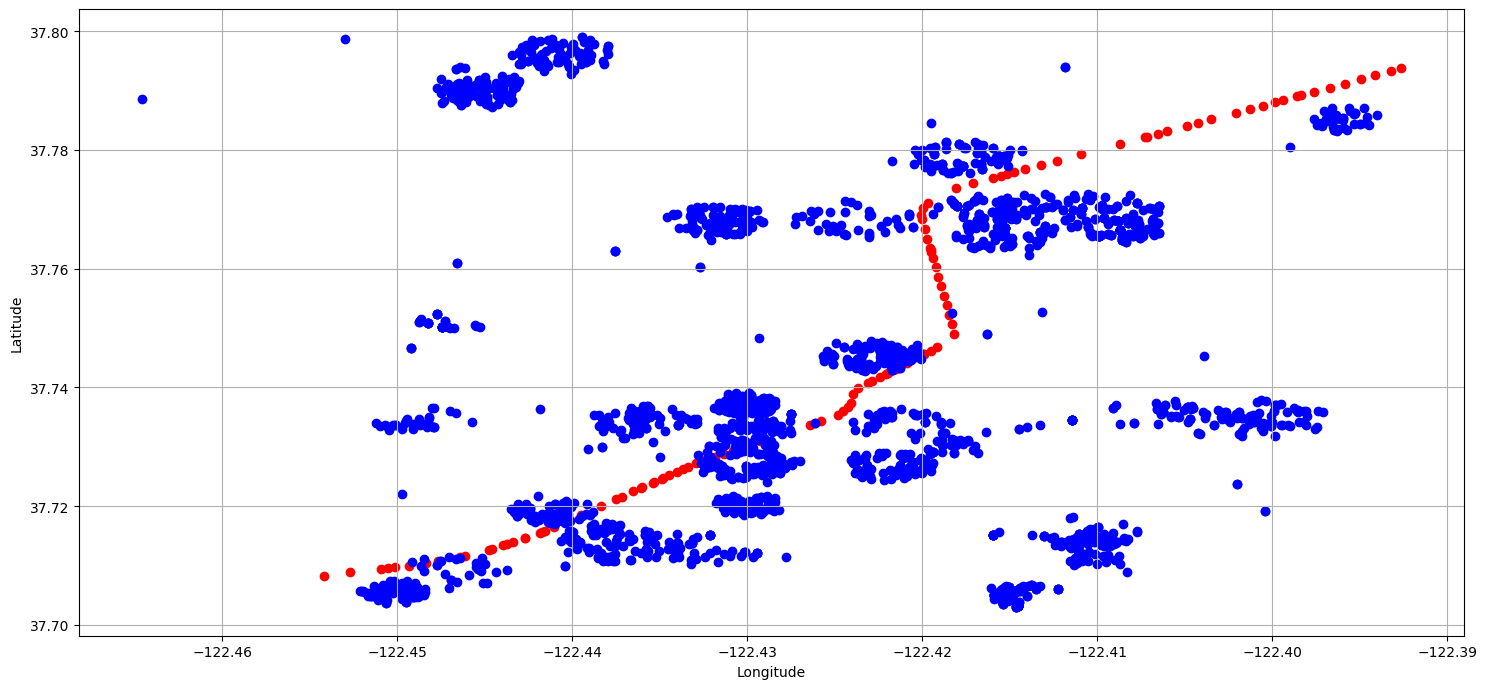

In [49]:
fig, axs = plt.subplots(1, 1, figsize=(15, 7))

# Plot 1 - potential bus stops
axs.scatter(b['longitude'], b['latitude'], c='red', marker='o')
axs.set_xlabel('Longitude'); axs.set_ylabel('Latitude'); axs.grid(True)

# Plot 2 - addresses of all employees
axs.scatter(a['longitude'], a['latitude'], c='blue', marker='o')
plt.tight_layout()

In [ ]:
# The possible combinations looks enormous for brute force and for Greedy approximation
import math 
n = 120
k = 10 
math.comb(n, k) / 1000000000 # billions

116068.178638776

# Synthetic data

- Get a smaller portion of b, as easier to work with, and syntethic a (addresses)

In [ ]:
from skopt import gp_minimize
from scipy.spatial.distance import cdist

a1 = pd.read_csv('synthetic1.csv').drop(columns="Unnamed: 0")
b1 = pd.read_csv('Potentail_Bust_Stops_lat_long_corrected.csv'
                 ).drop(columns="Unnamed: 0"
                 ).sample(n=30, random_state=42).sort_values(by='latitude')

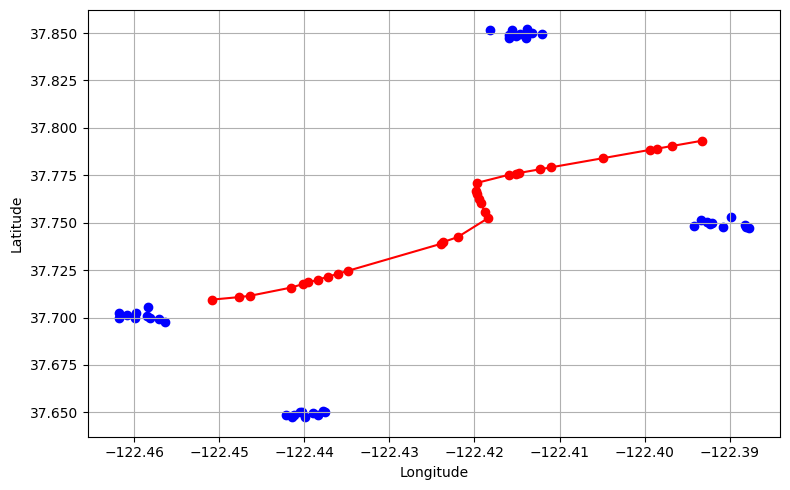

In [115]:
fig, axs = plt.subplots(1, 1, figsize=(8, 5))

# Plot 1 - potential bus stops
axs.plot(b1['longitude'], b1['latitude'], '-o', c='red')
axs.set_xlabel('Longitude'); axs.set_ylabel('Latitude'); axs.grid(True)

# Plot 2 - addresses of all employees
axs.scatter(a1['longitude'], a1['latitude'], c='blue', marker='o')
plt.tight_layout() 

In [116]:
b1 = b1[['latitude', 'longitude']].to_numpy()
a1 = a1[['latitude', 'longitude']].to_numpy()

In [117]:
n_points = len(b1)
subset_size = 4

initial_points = [x for x in range(14, 14+subset_size)]
initial_points 

[14, 15, 16, 17]

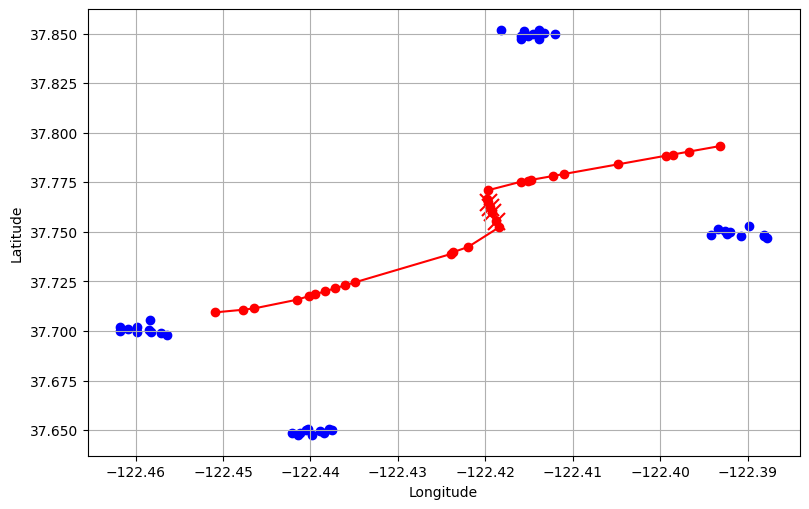

In [118]:
fig, axs = plt.subplots(1, 1, figsize=(8, 5))

# Plot 2 - addresses of all employees
axs.scatter(a1[:, 1], a1[:, 0], c='blue', marker='o')
plt.tight_layout() 

# Plot 1 - potential bus stops
axs.plot(b1[:, 1], b1[:, 0], '-o', c='red')
axs.set_xlabel('Longitude'); axs.set_ylabel('Latitude'); axs.grid(True)

# Plot 3 - initial bus stops random combinations
axs.scatter(b1[initial_points, 1], b1[initial_points, 0], c='red', marker='x', s=150); 

In [119]:
# Search space for the gp_minimization

from skopt.space import Integer

space = [Integer(0, n_points-1) for _ in range(subset_size)]
space

[Integer(low=0, high=29, prior='uniform', transform='identity'),
 Integer(low=0, high=29, prior='uniform', transform='identity'),
 Integer(low=0, high=29, prior='uniform', transform='identity'),
 Integer(low=0, high=29, prior='uniform', transform='identity')]

In [120]:
penalty = 1e10

def objective(indices):
    
    if len(set(indices)) != len(indices): 
        return penalty 
    
    selected_points = b1[np.array(indices, dtype=int)] 
    distances = cdist(a1, selected_points)
    return np.sum(np.min(distances, axis=1))

result = gp_minimize( func=objective, 
                      dimensions=space,  # Search space
                      acq_func="EI",     # Expected improvement
                      n_calls=200,       # Number of iterations
                      random_state=42,
                      x0=initial_points, 
                      n_restarts_optimizer=5, 
                      acq_optimizer = 'auto',
                      verbose=True ) 

Iteration No: 1 started. Evaluating function at provided point.
Iteration No: 1 ended. Evaluation done at provided point.
Time taken: 0.0000
Function value obtained: 2.8962
Current minimum: 2.8962
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.0000
Function value obtained: 10000000000.0000
Current minimum: 2.8962
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.0000
Function value obtained: 10000000000.0000
Current minimum: 2.8962
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.0000
Function value obtained: 1.8912
Current minimum: 1.8912
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 0.0000
Function value obtained: 1.6765
Current minimum: 1.6765
Iteration N

e:\onco-bert\.venv\lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [4, 17, 9, 23] before, using random point [1, 15, 4, 2]
  warnings.warn(


Iteration No: 55 ended. Search finished for the next optimal point.
Time taken: 0.3661
Function value obtained: 1.9738
Current minimum: 1.6426
Iteration No: 56 started. Searching for the next optimal point.
Iteration No: 56 ended. Search finished for the next optimal point.
Time taken: 0.3812
Function value obtained: 2.1040
Current minimum: 1.6426
Iteration No: 57 started. Searching for the next optimal point.
Iteration No: 57 ended. Search finished for the next optimal point.
Time taken: 0.4962
Function value obtained: 1.9724
Current minimum: 1.6426
Iteration No: 58 started. Searching for the next optimal point.
Iteration No: 58 ended. Search finished for the next optimal point.
Time taken: 0.4394
Function value obtained: 1.9640
Current minimum: 1.6426
Iteration No: 59 started. Searching for the next optimal point.


e:\onco-bert\.venv\lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [4, 17, 14, 22] before, using random point [26, 7, 24, 14]
  warnings.warn(


Iteration No: 59 ended. Search finished for the next optimal point.
Time taken: 0.3292
Function value obtained: 1.9458
Current minimum: 1.6426
Iteration No: 60 started. Searching for the next optimal point.
Iteration No: 60 ended. Search finished for the next optimal point.
Time taken: 0.3844
Function value obtained: 1.8860
Current minimum: 1.6426
Iteration No: 61 started. Searching for the next optimal point.
Iteration No: 61 ended. Search finished for the next optimal point.
Time taken: 0.3494
Function value obtained: 1.9524
Current minimum: 1.6426
Iteration No: 62 started. Searching for the next optimal point.
Iteration No: 62 ended. Search finished for the next optimal point.
Time taken: 0.3649
Function value obtained: 1.9955
Current minimum: 1.6426
Iteration No: 63 started. Searching for the next optimal point.
Iteration No: 63 ended. Search finished for the next optimal point.
Time taken: 0.3936
Function value obtained: 10000000000.0000
Current minimum: 1.6426
Iteration No: 64 st

e:\onco-bert\.venv\lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [4, 17, 11, 24] before, using random point [13, 22, 5, 12]
  warnings.warn(


Iteration No: 73 ended. Search finished for the next optimal point.
Time taken: 0.4520
Function value obtained: 1.9700
Current minimum: 1.6426
Iteration No: 74 started. Searching for the next optimal point.
Iteration No: 74 ended. Search finished for the next optimal point.
Time taken: 0.5822
Function value obtained: 10000000000.0000
Current minimum: 1.6426
Iteration No: 75 started. Searching for the next optimal point.
Iteration No: 75 ended. Search finished for the next optimal point.
Time taken: 0.4633
Function value obtained: 1.8909
Current minimum: 1.6426
Iteration No: 76 started. Searching for the next optimal point.
Iteration No: 76 ended. Search finished for the next optimal point.
Time taken: 0.5647
Function value obtained: 2.0336
Current minimum: 1.6426
Iteration No: 77 started. Searching for the next optimal point.
Iteration No: 77 ended. Search finished for the next optimal point.
Time taken: 0.5559
Function value obtained: 2.0110
Current minimum: 1.6426
Iteration No: 78 st

e:\onco-bert\.venv\lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [2, 15, 5, 1] before, using random point [7, 21, 22, 10]
  warnings.warn(


Iteration No: 88 ended. Search finished for the next optimal point.
Time taken: 0.6841
Function value obtained: 2.1065
Current minimum: 1.6426
Iteration No: 89 started. Searching for the next optimal point.
Iteration No: 89 ended. Search finished for the next optimal point.
Time taken: 0.6986
Function value obtained: 1.9933
Current minimum: 1.6426
Iteration No: 90 started. Searching for the next optimal point.
Iteration No: 90 ended. Search finished for the next optimal point.
Time taken: 0.6335
Function value obtained: 1.8357
Current minimum: 1.6426
Iteration No: 91 started. Searching for the next optimal point.
Iteration No: 91 ended. Search finished for the next optimal point.
Time taken: 0.6559
Function value obtained: 1.9933
Current minimum: 1.6426
Iteration No: 92 started. Searching for the next optimal point.
Iteration No: 92 ended. Search finished for the next optimal point.
Time taken: 0.6631
Function value obtained: 1.7025
Current minimum: 1.6426
Iteration No: 93 started. Sea

e:\onco-bert\.venv\lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [2, 15, 5, 11] before, using random point [26, 11, 22, 24]
  warnings.warn(


Iteration No: 93 ended. Search finished for the next optimal point.
Time taken: 0.7124
Function value obtained: 2.4197
Current minimum: 1.6426
Iteration No: 94 started. Searching for the next optimal point.


e:\onco-bert\.venv\lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [2, 15, 5, 6] before, using random point [1, 28, 15, 2]
  warnings.warn(


Iteration No: 94 ended. Search finished for the next optimal point.
Time taken: 0.6861
Function value obtained: 1.6976
Current minimum: 1.6426
Iteration No: 95 started. Searching for the next optimal point.


e:\onco-bert\.venv\lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [2, 15, 5, 6] before, using random point [5, 28, 22, 15]
  warnings.warn(


Iteration No: 95 ended. Search finished for the next optimal point.
Time taken: 0.7302
Function value obtained: 1.8813
Current minimum: 1.6426
Iteration No: 96 started. Searching for the next optimal point.


e:\onco-bert\.venv\lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [2, 15, 5, 7] before, using random point [9, 3, 16, 28]
  warnings.warn(


Iteration No: 96 ended. Search finished for the next optimal point.
Time taken: 0.8330
Function value obtained: 1.8333
Current minimum: 1.6426
Iteration No: 97 started. Searching for the next optimal point.


e:\onco-bert\.venv\lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [2, 15, 5, 7] before, using random point [18, 3, 8, 25]
  warnings.warn(


Iteration No: 97 ended. Search finished for the next optimal point.
Time taken: 0.8252
Function value obtained: 1.9002
Current minimum: 1.6426
Iteration No: 98 started. Searching for the next optimal point.


e:\onco-bert\.venv\lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [2, 15, 5, 1] before, using random point [11, 8, 13, 16]
  warnings.warn(


Iteration No: 98 ended. Search finished for the next optimal point.
Time taken: 0.8401
Function value obtained: 2.2116
Current minimum: 1.6426
Iteration No: 99 started. Searching for the next optimal point.


e:\onco-bert\.venv\lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [2, 15, 5, 7] before, using random point [2, 14, 26, 24]
  warnings.warn(


Iteration No: 99 ended. Search finished for the next optimal point.
Time taken: 0.9107
Function value obtained: 1.7119
Current minimum: 1.6426
Iteration No: 100 started. Searching for the next optimal point.
Iteration No: 100 ended. Search finished for the next optimal point.
Time taken: 0.9226
Function value obtained: 1.9933
Current minimum: 1.6426
Iteration No: 101 started. Searching for the next optimal point.
Iteration No: 101 ended. Search finished for the next optimal point.
Time taken: 0.8188
Function value obtained: 10000000000.0000
Current minimum: 1.6426
Iteration No: 102 started. Searching for the next optimal point.
Iteration No: 102 ended. Search finished for the next optimal point.
Time taken: 0.8119
Function value obtained: 1.8904
Current minimum: 1.6426
Iteration No: 103 started. Searching for the next optimal point.
Iteration No: 103 ended. Search finished for the next optimal point.
Time taken: 0.8174
Function value obtained: 10000000000.0000
Current minimum: 1.6426
I

e:\onco-bert\.venv\lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [15, 23, 16, 12] before, using random point [6, 10, 1, 2]
  warnings.warn(


Iteration No: 115 ended. Search finished for the next optimal point.
Time taken: 1.5668
Function value obtained: 2.2335
Current minimum: 1.6426
Iteration No: 116 started. Searching for the next optimal point.
Iteration No: 116 ended. Search finished for the next optimal point.
Time taken: 0.8824
Function value obtained: 2.0926
Current minimum: 1.6426
Iteration No: 117 started. Searching for the next optimal point.
Iteration No: 117 ended. Search finished for the next optimal point.
Time taken: 1.0333
Function value obtained: 1.7634
Current minimum: 1.6426
Iteration No: 118 started. Searching for the next optimal point.
Iteration No: 118 ended. Search finished for the next optimal point.
Time taken: 0.8260
Function value obtained: 2.0222
Current minimum: 1.6426
Iteration No: 119 started. Searching for the next optimal point.
Iteration No: 119 ended. Search finished for the next optimal point.
Time taken: 0.8327
Function value obtained: 1.9874
Current minimum: 1.6426
Iteration No: 120 st

e:\onco-bert\.venv\lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [0, 23, 16, 12] before, using random point [23, 22, 27, 20]
  warnings.warn(


Iteration No: 120 ended. Search finished for the next optimal point.
Time taken: 0.9700
Function value obtained: 3.1320
Current minimum: 1.6426
Iteration No: 121 started. Searching for the next optimal point.
Iteration No: 121 ended. Search finished for the next optimal point.
Time taken: 0.9878
Function value obtained: 1.8233
Current minimum: 1.6426
Iteration No: 122 started. Searching for the next optimal point.


e:\onco-bert\.venv\lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [8, 23, 16, 12] before, using random point [19, 17, 14, 27]
  warnings.warn(


Iteration No: 122 ended. Search finished for the next optimal point.
Time taken: 0.8721
Function value obtained: 2.6771
Current minimum: 1.6426
Iteration No: 123 started. Searching for the next optimal point.


e:\onco-bert\.venv\lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [13, 23, 16, 12] before, using random point [6, 19, 28, 15]
  warnings.warn(


Iteration No: 123 ended. Search finished for the next optimal point.
Time taken: 0.8884
Function value obtained: 1.9161
Current minimum: 1.6426
Iteration No: 124 started. Searching for the next optimal point.
Iteration No: 124 ended. Search finished for the next optimal point.
Time taken: 0.8985
Function value obtained: 2.5088
Current minimum: 1.6426
Iteration No: 125 started. Searching for the next optimal point.
Iteration No: 125 ended. Search finished for the next optimal point.
Time taken: 0.9173
Function value obtained: 2.4527
Current minimum: 1.6426
Iteration No: 126 started. Searching for the next optimal point.
Iteration No: 126 ended. Search finished for the next optimal point.
Time taken: 0.8659
Function value obtained: 2.1256
Current minimum: 1.6426
Iteration No: 127 started. Searching for the next optimal point.


e:\onco-bert\.venv\lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [5, 23, 16, 12] before, using random point [3, 20, 25, 9]
  warnings.warn(


Iteration No: 127 ended. Search finished for the next optimal point.
Time taken: 1.2654
Function value obtained: 1.9234
Current minimum: 1.6426
Iteration No: 128 started. Searching for the next optimal point.


e:\onco-bert\.venv\lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [14, 23, 16, 12] before, using random point [15, 23, 23, 7]
  warnings.warn(


Iteration No: 128 ended. Search finished for the next optimal point.
Time taken: 1.4028
Function value obtained: 10000000000.0000
Current minimum: 1.6426
Iteration No: 129 started. Searching for the next optimal point.
Iteration No: 129 ended. Search finished for the next optimal point.
Time taken: 1.2980
Function value obtained: 1.8174
Current minimum: 1.6426
Iteration No: 130 started. Searching for the next optimal point.


e:\onco-bert\.venv\lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [14, 23, 16, 12] before, using random point [8, 18, 13, 2]
  warnings.warn(


Iteration No: 130 ended. Search finished for the next optimal point.
Time taken: 1.1470
Function value obtained: 1.9029
Current minimum: 1.6426
Iteration No: 131 started. Searching for the next optimal point.
Iteration No: 131 ended. Search finished for the next optimal point.
Time taken: 1.2172
Function value obtained: 2.4587
Current minimum: 1.6426
Iteration No: 132 started. Searching for the next optimal point.


e:\onco-bert\.venv\lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [13, 23, 16, 12] before, using random point [19, 23, 2, 20]
  warnings.warn(


Iteration No: 132 ended. Search finished for the next optimal point.
Time taken: 1.0610
Function value obtained: 1.8683
Current minimum: 1.6426
Iteration No: 133 started. Searching for the next optimal point.
Iteration No: 133 ended. Search finished for the next optimal point.
Time taken: 1.2049
Function value obtained: 10000000000.0000
Current minimum: 1.6426
Iteration No: 134 started. Searching for the next optimal point.
Iteration No: 134 ended. Search finished for the next optimal point.
Time taken: 1.0675
Function value obtained: 1.9365
Current minimum: 1.6426
Iteration No: 135 started. Searching for the next optimal point.
Iteration No: 135 ended. Search finished for the next optimal point.
Time taken: 1.0484
Function value obtained: 1.9930
Current minimum: 1.6426
Iteration No: 136 started. Searching for the next optimal point.
Iteration No: 136 ended. Search finished for the next optimal point.
Time taken: 1.1663
Function value obtained: 1.9878
Current minimum: 1.6426
Iteration 

In [121]:
best_indices = result.x
selected_points = b1[np.array(best_indices, dtype=int)]

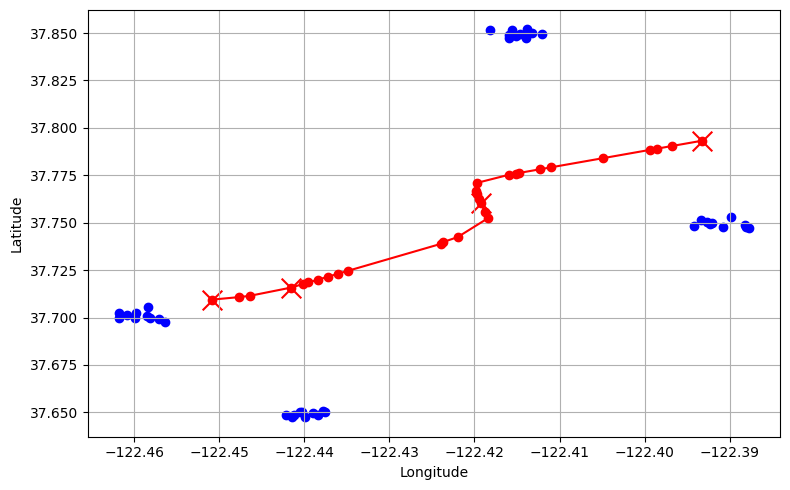

In [122]:
fig, axs = plt.subplots(1, 1, figsize=(8, 5))

# Plot 1 - potential bus stops
axs.plot(b1[:, 1], b1[:, 0], '-o', c='red')
axs.set_xlabel('Longitude'); axs.set_ylabel('Latitude'); axs.grid(True)

# Plot 2 - addresses of all employees
axs.scatter(a1[:, 1], a1[:, 0], c='blue', marker='o')

# Plot 3 - selected points after optimization
axs.scatter(selected_points[:, 1], selected_points[:, 0], c='red', marker='x', s=200)
plt.tight_layout()

In [ ]:
if False: 
    results_func_vals = result.func_vals[result.func_vals < penalty]
    plt.plot(range(1, len(results_func_vals) + 1), results_func_vals, linestyle='-')
    plt.xlabel('Iteration (cleaned)'); plt.ylabel('Objective Value'); 

# Introduce prior to the GP using K-means 

In [139]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=subset_size, random_state=42).fit(a1)
clusters = kmeans.cluster_centers_

selected_indices = set()
initial_points_clusters = []

for center in clusters:
    distances = np.sum((b1 - center) ** 2, axis=1)
    sorted_indices = np.argsort(distances)
    for idx in sorted_indices:
        if idx not in selected_indices:
            initial_points_clusters.append(idx)
            selected_indices.add(idx)
            break

#initial_points_clusters = [np.argmin(np.sum((b1 - cluster)**2, axis=1)) for cluster in clusters]

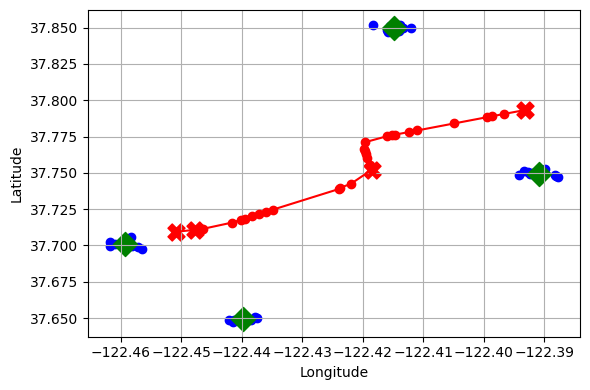

In [140]:
fig, axs = plt.subplots(1, 1, figsize=(6, 4))

# Plot 1 - potential bus stops
axs.plot(b1[:, 1], b1[:, 0], '-o', c='red')
axs.set_xlabel('Longitude'); axs.set_ylabel('Latitude'); axs.grid(True)

# Plot 2 - addresses of all employees
axs.scatter(a1[:, 1], a1[:, 0], c='blue', marker='o')

# Plot 3 - selected points after optimization
axs.scatter(clusters[:, 1], clusters[:, 0], c='green', marker='D', s=150)
plt.tight_layout(); 

# Plot 4 -  initial_points_clusters
axs.scatter( b1[initial_points_clusters, 1], b1[initial_points_clusters, 0], c='red', marker='X', s=150 )

In [143]:
# Set initial_points_clusters instead of initial_points

penalty = 1e10

def objective(indices):
    
    if len(set(indices)) != len(indices): 
        return penalty 
    
    selected_points = b1[np.array(indices, dtype=int)] 
    distances = cdist(a1, selected_points)
    return np.sum(np.min(distances, axis=1))

result = gp_minimize( func=objective, 
                      dimensions=space,  # Search space
                      acq_func="EI",     # Expected improvement
                      n_calls=200,       # Number of iterations
                      random_state=42,
                      x0=initial_points_clusters, 
                      n_restarts_optimizer=5, 
                      acq_optimizer = 'auto',
                      verbose=True ) 

Iteration No: 1 started. Evaluating function at provided point.
Iteration No: 1 ended. Evaluation done at provided point.
Time taken: 0.0010
Function value obtained: 1.6161
Current minimum: 1.6161
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.0004
Function value obtained: 10000000000.0000
Current minimum: 1.6161
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.0010
Function value obtained: 10000000000.0000
Current minimum: 1.6161
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.0000
Function value obtained: 1.8912
Current minimum: 1.6161
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 0.0011
Function value obtained: 1.6765
Current minimum: 1.6161
Iteration N

e:\onco-bert\.venv\lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [9, 25, 24, 15] before, using random point [18, 14, 28, 26]
  warnings.warn(


Iteration No: 85 ended. Search finished for the next optimal point.
Time taken: 0.5163
Function value obtained: 2.6679
Current minimum: 1.6161
Iteration No: 86 started. Searching for the next optimal point.
Iteration No: 86 ended. Search finished for the next optimal point.
Time taken: 0.5663
Function value obtained: 1.7940
Current minimum: 1.6161
Iteration No: 87 started. Searching for the next optimal point.
Iteration No: 87 ended. Search finished for the next optimal point.
Time taken: 0.5834
Function value obtained: 2.0764
Current minimum: 1.6161
Iteration No: 88 started. Searching for the next optimal point.


e:\onco-bert\.venv\lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [9, 25, 24, 18] before, using random point [10, 3, 2, 17]
  warnings.warn(


Iteration No: 88 ended. Search finished for the next optimal point.
Time taken: 0.5831
Function value obtained: 1.9700
Current minimum: 1.6161
Iteration No: 89 started. Searching for the next optimal point.
Iteration No: 89 ended. Search finished for the next optimal point.
Time taken: 0.5997
Function value obtained: 2.1190
Current minimum: 1.6161
Iteration No: 90 started. Searching for the next optimal point.
Iteration No: 90 ended. Search finished for the next optimal point.
Time taken: 0.5666
Function value obtained: 2.6771
Current minimum: 1.6161
Iteration No: 91 started. Searching for the next optimal point.


e:\onco-bert\.venv\lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [9, 25, 24, 15] before, using random point [7, 25, 0, 8]
  warnings.warn(


Iteration No: 91 ended. Search finished for the next optimal point.
Time taken: 0.6165
Function value obtained: 1.7729
Current minimum: 1.6161
Iteration No: 92 started. Searching for the next optimal point.


e:\onco-bert\.venv\lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [9, 25, 24, 15] before, using random point [26, 4, 22, 16]
  warnings.warn(


Iteration No: 92 ended. Search finished for the next optimal point.
Time taken: 0.5999
Function value obtained: 1.8887
Current minimum: 1.6161
Iteration No: 93 started. Searching for the next optimal point.
Iteration No: 93 ended. Search finished for the next optimal point.
Time taken: 0.6164
Function value obtained: 1.9271
Current minimum: 1.6161
Iteration No: 94 started. Searching for the next optimal point.
Iteration No: 94 ended. Search finished for the next optimal point.
Time taken: 0.6333
Function value obtained: 1.8506
Current minimum: 1.6161
Iteration No: 95 started. Searching for the next optimal point.


e:\onco-bert\.venv\lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [9, 25, 24, 15] before, using random point [17, 4, 19, 6]
  warnings.warn(


Iteration No: 95 ended. Search finished for the next optimal point.
Time taken: 0.5594
Function value obtained: 2.0571
Current minimum: 1.6161
Iteration No: 96 started. Searching for the next optimal point.
Iteration No: 96 ended. Search finished for the next optimal point.
Time taken: 0.6067
Function value obtained: 2.1197
Current minimum: 1.6161
Iteration No: 97 started. Searching for the next optimal point.


e:\onco-bert\.venv\lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [9, 25, 24, 14] before, using random point [4, 24, 12, 17]
  warnings.warn(


Iteration No: 97 ended. Search finished for the next optimal point.
Time taken: 0.6989
Function value obtained: 1.9633
Current minimum: 1.6161
Iteration No: 98 started. Searching for the next optimal point.
Iteration No: 98 ended. Search finished for the next optimal point.
Time taken: 0.6291
Function value obtained: 2.4375
Current minimum: 1.6161
Iteration No: 99 started. Searching for the next optimal point.
Iteration No: 99 ended. Search finished for the next optimal point.
Time taken: 0.6382
Function value obtained: 2.0890
Current minimum: 1.6161
Iteration No: 100 started. Searching for the next optimal point.
Iteration No: 100 ended. Search finished for the next optimal point.
Time taken: 0.5996
Function value obtained: 2.1507
Current minimum: 1.6161
Iteration No: 101 started. Searching for the next optimal point.


e:\onco-bert\.venv\lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [9, 25, 24, 14] before, using random point [1, 11, 9, 15]
  warnings.warn(


Iteration No: 101 ended. Search finished for the next optimal point.
Time taken: 0.7625
Function value obtained: 1.9738
Current minimum: 1.6161
Iteration No: 102 started. Searching for the next optimal point.


e:\onco-bert\.venv\lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [19, 0, 1, 17] before, using random point [20, 15, 4, 29]
  warnings.warn(


Iteration No: 102 ended. Search finished for the next optimal point.
Time taken: 0.7028
Function value obtained: 1.8490
Current minimum: 1.6161
Iteration No: 103 started. Searching for the next optimal point.
Iteration No: 103 ended. Search finished for the next optimal point.
Time taken: 0.7331
Function value obtained: 2.0794
Current minimum: 1.6161
Iteration No: 104 started. Searching for the next optimal point.


e:\onco-bert\.venv\lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [9, 25, 24, 16] before, using random point [10, 17, 28, 21]
  warnings.warn(


Iteration No: 104 ended. Search finished for the next optimal point.
Time taken: 0.7332
Function value obtained: 2.3772
Current minimum: 1.6161
Iteration No: 105 started. Searching for the next optimal point.


e:\onco-bert\.venv\lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [9, 25, 24, 17] before, using random point [15, 10, 26, 29]
  warnings.warn(


Iteration No: 105 ended. Search finished for the next optimal point.
Time taken: 0.7669
Function value obtained: 2.3379
Current minimum: 1.6161
Iteration No: 106 started. Searching for the next optimal point.


e:\onco-bert\.venv\lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [9, 25, 24, 13] before, using random point [13, 8, 21, 18]
  warnings.warn(


Iteration No: 106 ended. Search finished for the next optimal point.
Time taken: 0.7990
Function value obtained: 2.0786
Current minimum: 1.6161
Iteration No: 107 started. Searching for the next optimal point.
Iteration No: 107 ended. Search finished for the next optimal point.
Time taken: 0.7626
Function value obtained: 1.9801
Current minimum: 1.6161
Iteration No: 108 started. Searching for the next optimal point.


e:\onco-bert\.venv\lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [9, 25, 24, 17] before, using random point [10, 5, 24, 25]
  warnings.warn(


Iteration No: 108 ended. Search finished for the next optimal point.
Time taken: 0.7520
Function value obtained: 1.9663
Current minimum: 1.6161
Iteration No: 109 started. Searching for the next optimal point.


e:\onco-bert\.venv\lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [9, 25, 24, 17] before, using random point [13, 24, 10, 2]
  warnings.warn(


Iteration No: 109 ended. Search finished for the next optimal point.
Time taken: 0.7540
Function value obtained: 1.7771
Current minimum: 1.6161
Iteration No: 110 started. Searching for the next optimal point.
Iteration No: 110 ended. Search finished for the next optimal point.
Time taken: 0.8828
Function value obtained: 1.7867
Current minimum: 1.6161
Iteration No: 111 started. Searching for the next optimal point.
Iteration No: 111 ended. Search finished for the next optimal point.
Time taken: 0.7808
Function value obtained: 2.1201
Current minimum: 1.6161
Iteration No: 112 started. Searching for the next optimal point.


e:\onco-bert\.venv\lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [9, 25, 24, 16] before, using random point [6, 22, 27, 26]
  warnings.warn(


Iteration No: 112 ended. Search finished for the next optimal point.
Time taken: 0.7676
Function value obtained: 1.9811
Current minimum: 1.6161
Iteration No: 113 started. Searching for the next optimal point.
Iteration No: 113 ended. Search finished for the next optimal point.
Time taken: 0.8513
Function value obtained: 2.0176
Current minimum: 1.6161
Iteration No: 114 started. Searching for the next optimal point.


e:\onco-bert\.venv\lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [9, 25, 24, 15] before, using random point [27, 10, 16, 28]
  warnings.warn(


Iteration No: 114 ended. Search finished for the next optimal point.
Time taken: 0.7985
Function value obtained: 2.3645
Current minimum: 1.6161
Iteration No: 115 started. Searching for the next optimal point.
Iteration No: 115 ended. Search finished for the next optimal point.
Time taken: 0.9306
Function value obtained: 2.0560
Current minimum: 1.6161
Iteration No: 116 started. Searching for the next optimal point.
Iteration No: 116 ended. Search finished for the next optimal point.
Time taken: 0.7542
Function value obtained: 1.9208
Current minimum: 1.6161
Iteration No: 117 started. Searching for the next optimal point.
Iteration No: 117 ended. Search finished for the next optimal point.
Time taken: 0.8008
Function value obtained: 1.8940
Current minimum: 1.6161
Iteration No: 118 started. Searching for the next optimal point.
Iteration No: 118 ended. Search finished for the next optimal point.
Time taken: 0.7477
Function value obtained: 1.7135
Current minimum: 1.6161
Iteration No: 119 st

e:\onco-bert\.venv\lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [7, 25, 24, 17] before, using random point [26, 12, 17, 28]
  warnings.warn(


Iteration No: 136 ended. Search finished for the next optimal point.
Time taken: 2.3982
Function value obtained: 2.4435
Current minimum: 1.6161
Iteration No: 137 started. Searching for the next optimal point.
Iteration No: 137 ended. Search finished for the next optimal point.
Time taken: 1.0501
Function value obtained: 2.0934
Current minimum: 1.6161
Iteration No: 138 started. Searching for the next optimal point.
Iteration No: 138 ended. Search finished for the next optimal point.
Time taken: 1.1665
Function value obtained: 2.0375
Current minimum: 1.6161
Iteration No: 139 started. Searching for the next optimal point.
Iteration No: 139 ended. Search finished for the next optimal point.
Time taken: 1.6693
Function value obtained: 2.0380
Current minimum: 1.6161
Iteration No: 140 started. Searching for the next optimal point.
Iteration No: 140 ended. Search finished for the next optimal point.
Time taken: 1.1964
Function value obtained: 1.8912
Current minimum: 1.6161
Iteration No: 141 st

e:\onco-bert\.venv\lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [3, 25, 20, 17] before, using random point [28, 24, 5, 11]
  warnings.warn(


Iteration No: 157 ended. Search finished for the next optimal point.
Time taken: 2.0361
Function value obtained: 1.9166
Current minimum: 1.6161
Iteration No: 158 started. Searching for the next optimal point.
Iteration No: 158 ended. Search finished for the next optimal point.
Time taken: 2.0308
Function value obtained: 10000000000.0000
Current minimum: 1.6161
Iteration No: 159 started. Searching for the next optimal point.
Iteration No: 159 ended. Search finished for the next optimal point.
Time taken: 1.7644
Function value obtained: 2.3980
Current minimum: 1.6161
Iteration No: 160 started. Searching for the next optimal point.
Iteration No: 160 ended. Search finished for the next optimal point.
Time taken: 2.1323
Function value obtained: 2.3980
Current minimum: 1.6161
Iteration No: 161 started. Searching for the next optimal point.
Iteration No: 161 ended. Search finished for the next optimal point.
Time taken: 1.6165
Function value obtained: 10000000000.0000
Current minimum: 1.6161


e:\onco-bert\.venv\lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [8, 25, 24, 17] before, using random point [9, 13, 15, 20]
  warnings.warn(


Iteration No: 169 ended. Search finished for the next optimal point.
Time taken: 1.7989
Function value obtained: 2.1178
Current minimum: 1.6161
Iteration No: 170 started. Searching for the next optimal point.
Iteration No: 170 ended. Search finished for the next optimal point.
Time taken: 2.0826
Function value obtained: 1.8407
Current minimum: 1.6161
Iteration No: 171 started. Searching for the next optimal point.
Iteration No: 171 ended. Search finished for the next optimal point.
Time taken: 2.2687
Function value obtained: 1.9586
Current minimum: 1.6161
Iteration No: 172 started. Searching for the next optimal point.


e:\onco-bert\.venv\lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [9, 25, 24, 18] before, using random point [27, 5, 2, 15]
  warnings.warn(


Iteration No: 172 ended. Search finished for the next optimal point.
Time taken: 2.6463
Function value obtained: 1.7263
Current minimum: 1.6161
Iteration No: 173 started. Searching for the next optimal point.
Iteration No: 173 ended. Search finished for the next optimal point.
Time taken: 2.1509
Function value obtained: 2.4570
Current minimum: 1.6161
Iteration No: 174 started. Searching for the next optimal point.
Iteration No: 174 ended. Search finished for the next optimal point.
Time taken: 2.1144
Function value obtained: 1.7042
Current minimum: 1.6161
Iteration No: 175 started. Searching for the next optimal point.
Iteration No: 175 ended. Search finished for the next optimal point.
Time taken: 2.0788
Function value obtained: 1.7833
Current minimum: 1.6161
Iteration No: 176 started. Searching for the next optimal point.
Iteration No: 176 ended. Search finished for the next optimal point.
Time taken: 2.3530
Function value obtained: 1.8998
Current minimum: 1.6161
Iteration No: 177 st

e:\onco-bert\.venv\lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [8, 25, 24, 17] before, using random point [15, 13, 17, 23]
  warnings.warn(


Iteration No: 181 ended. Search finished for the next optimal point.
Time taken: 4.3908
Function value obtained: 2.7022
Current minimum: 1.6161
Iteration No: 182 started. Searching for the next optimal point.
Iteration No: 182 ended. Search finished for the next optimal point.
Time taken: 3.0989
Function value obtained: 1.8063
Current minimum: 1.6161
Iteration No: 183 started. Searching for the next optimal point.
Iteration No: 183 ended. Search finished for the next optimal point.
Time taken: 3.5220
Function value obtained: 1.8009
Current minimum: 1.6161
Iteration No: 184 started. Searching for the next optimal point.
Iteration No: 184 ended. Search finished for the next optimal point.
Time taken: 4.4086
Function value obtained: 1.7172
Current minimum: 1.6161
Iteration No: 185 started. Searching for the next optimal point.
Iteration No: 185 ended. Search finished for the next optimal point.
Time taken: 3.1877
Function value obtained: 1.6243
Current minimum: 1.6161
Iteration No: 186 st

e:\onco-bert\.venv\lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [7, 19, 2, 22] before, using random point [7, 6, 14, 3]
  warnings.warn(


Iteration No: 190 ended. Search finished for the next optimal point.
Time taken: 3.0310
Function value obtained: 2.1269
Current minimum: 1.6161
Iteration No: 191 started. Searching for the next optimal point.
Iteration No: 191 ended. Search finished for the next optimal point.
Time taken: 3.2205
Function value obtained: 1.8443
Current minimum: 1.6161
Iteration No: 192 started. Searching for the next optimal point.


e:\onco-bert\.venv\lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [9, 25, 24, 17] before, using random point [3, 28, 21, 3]
  warnings.warn(


Iteration No: 192 ended. Search finished for the next optimal point.
Time taken: 2.3812
Function value obtained: 10000000000.0000
Current minimum: 1.6161
Iteration No: 193 started. Searching for the next optimal point.


e:\onco-bert\.venv\lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [8, 25, 24, 16] before, using random point [3, 16, 7, 4]
  warnings.warn(


Iteration No: 193 ended. Search finished for the next optimal point.
Time taken: 2.4152
Function value obtained: 2.0849
Current minimum: 1.6161
Iteration No: 194 started. Searching for the next optimal point.
Iteration No: 194 ended. Search finished for the next optimal point.
Time taken: 2.6778
Function value obtained: 2.1199
Current minimum: 1.6161
Iteration No: 195 started. Searching for the next optimal point.
Iteration No: 195 ended. Search finished for the next optimal point.
Time taken: 2.5692
Function value obtained: 2.1199
Current minimum: 1.6161
Iteration No: 196 started. Searching for the next optimal point.
Iteration No: 196 ended. Search finished for the next optimal point.
Time taken: 3.6809
Function value obtained: 2.5031
Current minimum: 1.6161
Iteration No: 197 started. Searching for the next optimal point.


e:\onco-bert\.venv\lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [7, 19, 15, 17] before, using random point [11, 2, 7, 18]
  warnings.warn(


Iteration No: 197 ended. Search finished for the next optimal point.
Time taken: 3.3167
Function value obtained: 1.9602
Current minimum: 1.6161
Iteration No: 198 started. Searching for the next optimal point.


e:\onco-bert\.venv\lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [9, 25, 24, 17] before, using random point [26, 1, 16, 13]
  warnings.warn(


Iteration No: 198 ended. Search finished for the next optimal point.
Time taken: 3.2665
Function value obtained: 1.6842
Current minimum: 1.6161
Iteration No: 199 started. Searching for the next optimal point.


e:\onco-bert\.venv\lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [8, 25, 24, 16] before, using random point [1, 20, 8, 11]
  warnings.warn(


Iteration No: 199 ended. Search finished for the next optimal point.
Time taken: 3.0980
Function value obtained: 1.8583
Current minimum: 1.6161
Iteration No: 200 started. Searching for the next optimal point.
Iteration No: 200 ended. Search finished for the next optimal point.
Time taken: 3.7473
Function value obtained: 1.8875
Current minimum: 1.6161


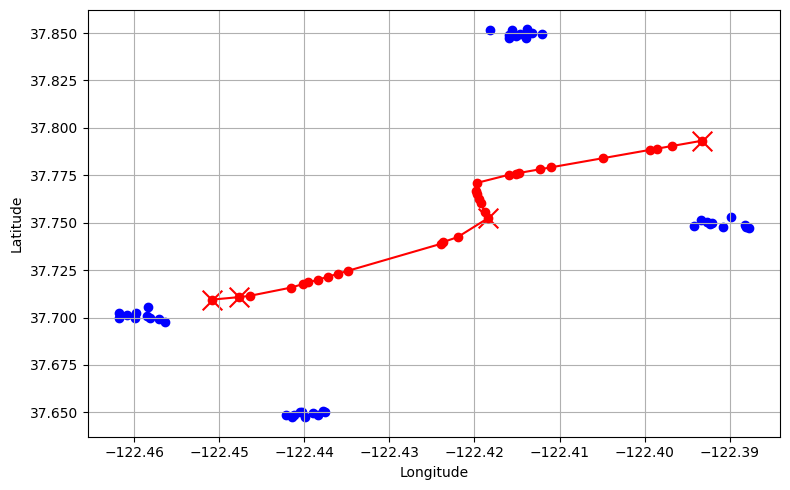

In [144]:
best_indices = result.x
selected_points = b1[np.array(best_indices, dtype=int)]

fig, axs = plt.subplots(1, 1, figsize=(8, 5))

# Plot 1 - potential bus stops
axs.plot(b1[:, 1], b1[:, 0], '-o', c='red')
axs.set_xlabel('Longitude'); axs.set_ylabel('Latitude'); axs.grid(True)

# Plot 2 - addresses of all employees
axs.scatter(a1[:, 1], a1[:, 0], c='blue', marker='o')

# Plot 3 - selected points after optimization
axs.scatter(selected_points[:, 1], selected_points[:, 0], c='red', marker='x', s=200)
plt.tight_layout();

In [146]:
result.fun

1.6161058669287012

In [ ]:
if False: 
    def objective(indices):
    
        selected_points = b1[np.array(indices, dtype=int)] 
        distances = cdist(a1, selected_points)             
        return np.sum(np.min(distances, axis=1))
    
    
    all_combinations = list(combinations(range(n_points), subset_size))
    space = [Categorical(all_combinations)]



In [ ]:
if False: 

    a1 = a[['latitude', 'longitude']].sample(n=25, random_state=49)
    b1 = b[['latitude', 'longitude']].sample(n=20, random_state=42).sort_values(by='latitude')

    fig, axs = plt.subplots(1, 1, figsize=(15, 7))

    # Plot 1 - potential bus stops
    axs.plot(b1['longitude'], b1['latitude'], '-o', c='red')
    axs.set_xlabel('Longitude'); axs.set_ylabel('Latitude'); axs.grid(True)

    # Plot 2 - addresses of all employees
    axs.scatter(a1['longitude'], a1['latitude'], c='blue', marker='o')
    plt.tight_layout() 